In [1]:
# Cell 1: imports and display options
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Display settings
pd.set_option('display.float_format', '{:.2f}'.format)
sns.set(style='whitegrid')

# For reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [3]:
# Cell 2: create synthetic dataset
import numpy as np
import pandas as pd

n_samples = 500

# Use 'ME' instead of deprecated 'M'
months = pd.date_range(start='2015-01-01', periods=n_samples, freq='ME')

# Regions: example regions in UK
regions = ['Scotland', 'England', 'Wales', 'Northern Ireland']
region = np.random.choice(regions, size=n_samples, p=[0.4, 0.4, 0.1, 0.1])

# Demographic features (synthetic):
income_mean = {
    'Scotland': 30000,
    'England': 32000,
    'Wales': 28000,
    'Northern Ireland': 27000
}
income = np.array([np.random.normal(income_mean[r], 2000) for r in region])

density_mean = {
    'Scotland': 70,
    'England': 430,
    'Wales': 150,
    'Northern Ireland': 135
}
density = np.array([np.random.normal(density_mean[r], 20) for r in region])

# Marketing spend for that month (thousands GBP)
marketing_spend = np.random.uniform(50, 200, size=n_samples)

# Seasonality factor: higher in summer months
month_num = months.month
seasonality = np.where(np.isin(month_num, [6, 7, 8]), 1.2, 1.0)

# Base sales (thousands of units) plus noise
base_sales = 100
sales = (
    base_sales
    + 0.001 * income
    + 0.05 * density
    + 0.3 * marketing_spend
) * seasonality

sales += np.random.normal(0, 5, size=n_samples)

# Profit margin percentage (synthetic)
base_margin = 0.15
margin = (
    base_margin
    + 0.0002 * income
    - 0.0003 * density
    - 0.0004 * marketing_spend
)

margin += np.random.normal(0, 0.02, size=n_samples)
margin = np.clip(margin, 0.05, 0.30)

# Build DataFrame
df = pd.DataFrame({
    'month': months,
    'region': region,
    'income': income,
    'density': density,
    'marketing_spend': marketing_spend,
    'seasonality': seasonality,
    'sales': sales,
    'profit_margin': margin
})

df.head()

,month,region,income,density,marketing_spend,seasonality,sales,profit_margin
0,2015-01-31,Scotland,27606.42,119.70,120.16,1.00,166.66,0.30
1,2015-02-28,England,33787.40,435.30,140.88,1.00,196.32,0.30
2,2015-03-31,Scotland,31785.91,95.51,114.25,1.00,174.88,0.30
3,2015-04-30,Scotland,33659.24,66.97,54.07,1.00,150.31,0.30
4,2015-05-31,Scotland,29180.63,80.67,167.53,1.00,179.72,0.30


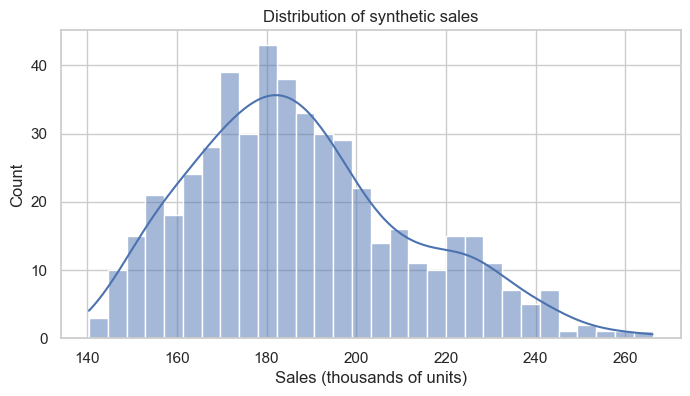

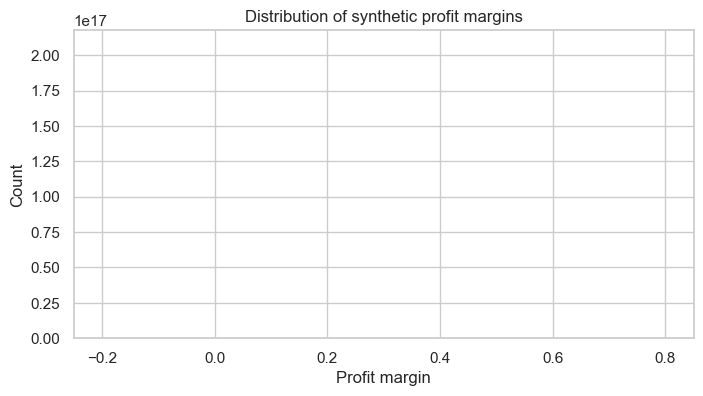

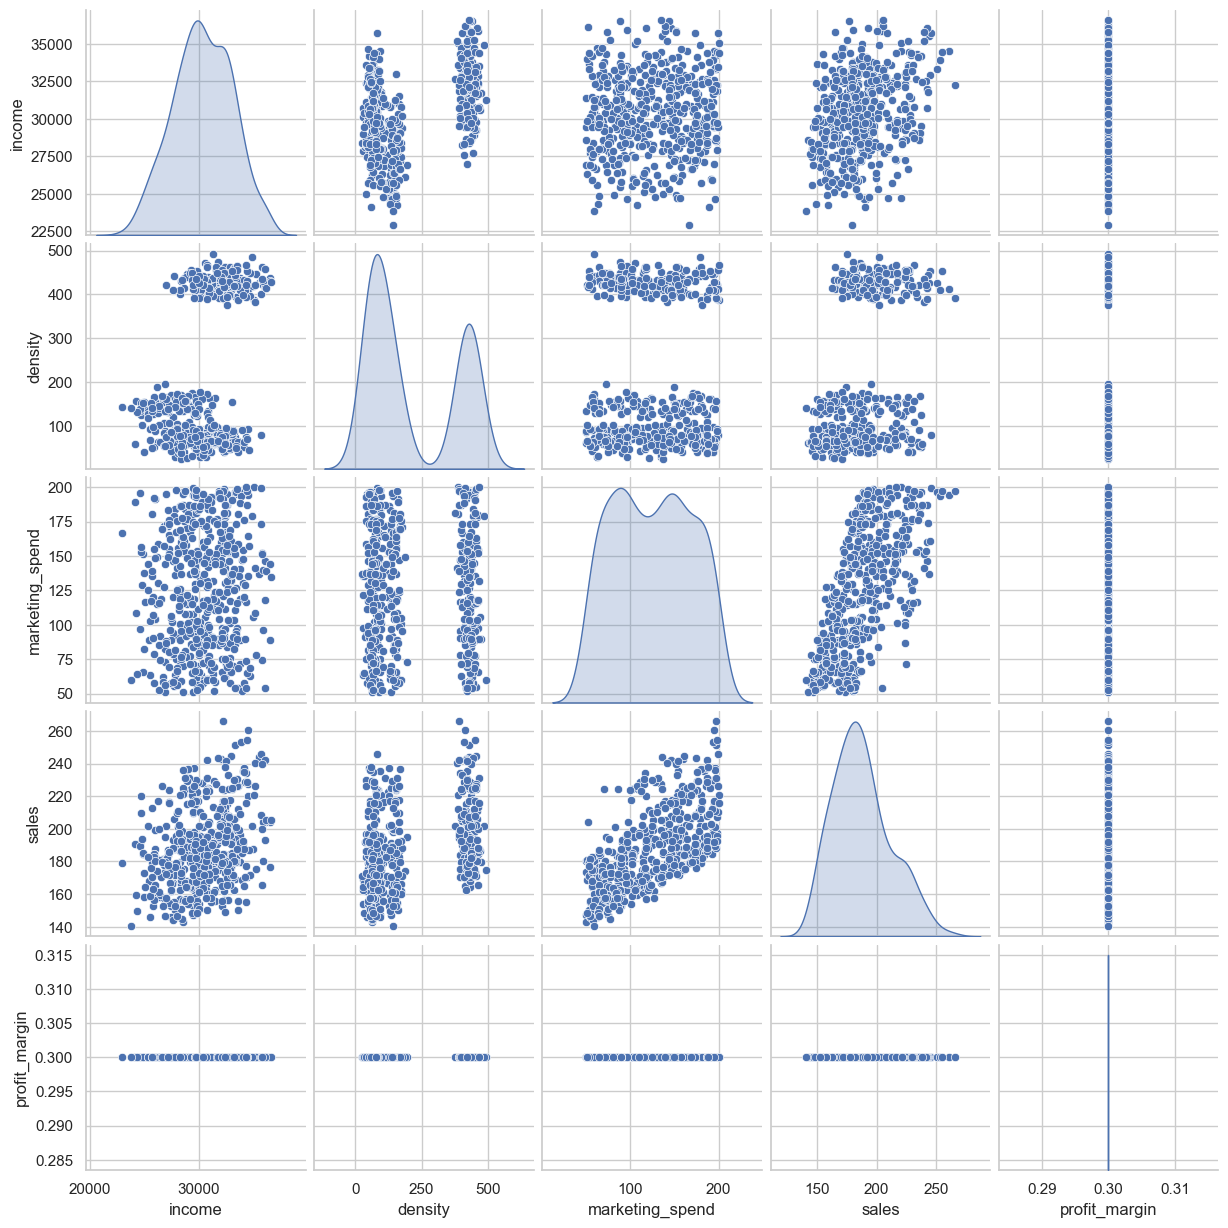

In [4]:
# Cell 3: quick stats
df.describe().T

# Cell 4: sales histogram
plt.figure(figsize=(8,4))
sns.histplot(df['sales'], bins=30, kde=True)
plt.title('Distribution of synthetic sales')
plt.xlabel('Sales (thousands of units)')
plt.show()

# Cell 5: profit margin histogram
plt.figure(figsize=(8,4))
sns.histplot(df['profit_margin'], bins=30, kde=True)
plt.title('Distribution of synthetic profit margins')
plt.xlabel('Profit margin')
plt.show()

# Cell 6: pairwise scatter plots on key numeric features
sns.pairplot(df[['income', 'density', 'marketing_spend', 'sales', 'profit_margin']], 
             kind='scatter', diag_kind='kde', height=2.5)
plt.show()

In [5]:
# Cell 7: prepare features
# Numeric features for regression
features = ['income', 'density', 'marketing_spend', 'seasonality']

X = df[features]
y_sales = df['sales']

# Train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_sales, test_size=0.2, random_state=RANDOM_SEED)

# Fit linear regression
lr_sales = LinearRegression()
lr_sales.fit(X_train, y_train)

# Predictions
y_pred = lr_sales.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Sales model RMSE: {rmse:.2f}")
print(f"Sales model R2: {r2:.3f}")

# Coefficients
coef_df = pd.DataFrame({
    'feature': features,
    'coefficient': lr_sales.coef_
})
coef_df

Sales model RMSE: 6.09
Sales model R2: 0.934


,feature,coefficient
0,income,0.00
1,density,0.05
2,marketing_spend,0.32
3,seasonality,180.06


In [6]:
# Cell 8: prepare target profit_margin
y_margin = df['profit_margin']

# Split
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X, y_margin, test_size=0.2, random_state=RANDOM_SEED)

# Fit model
lr_margin = LinearRegression()
lr_margin.fit(X_train_m, y_train_m)

# Predictions
y_pred_m = lr_margin.predict(X_test_m)

# Evaluation
mse_m = mean_squared_error(y_test_m, y_pred_m)
rmse_m = np.sqrt(mse_m)
r2_m = r2_score(y_test_m, y_pred_m)

print(f"Profit margin model RMSE: {rmse_m:.4f}")
print(f"Profit margin model R2: {r2_m:.3f}")

# Coefficients
coef_df_margin = pd.DataFrame({
    'feature': features,
    'coefficient': lr_margin.coef_
})
coef_df_margin

Profit margin model RMSE: 0.0000
Profit margin model R2: 0.000


,feature,coefficient
0,income,0.00
1,density,-0.00
2,marketing_spend,-0.00
3,seasonality,-0.00


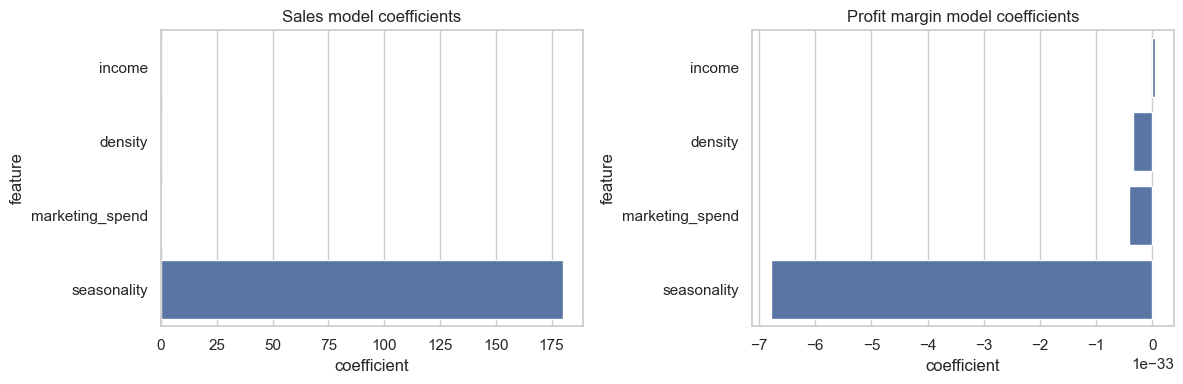

In [7]:
# Cell 9: coefficient bar charts
fig, axes = plt.subplots(1, 2, figsize=(12,4))

sns.barplot(x='coefficient', y='feature', data=coef_df, ax=axes[0])
axes[0].set_title('Sales model coefficients')

sns.barplot(x='coefficient', y='feature', data=coef_df_margin, ax=axes[1])
axes[1].set_title('Profit margin model coefficients')

plt.tight_layout()
plt.show()

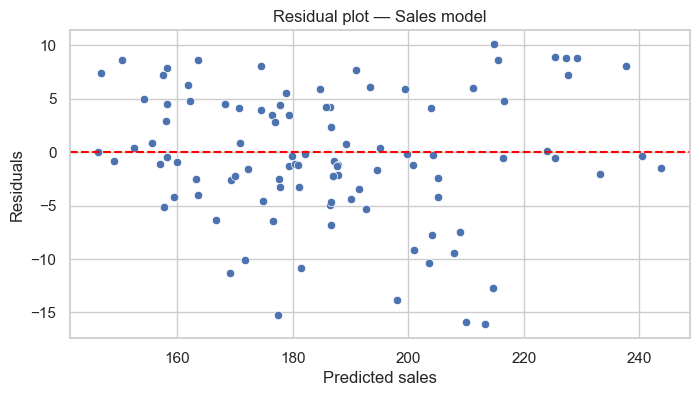

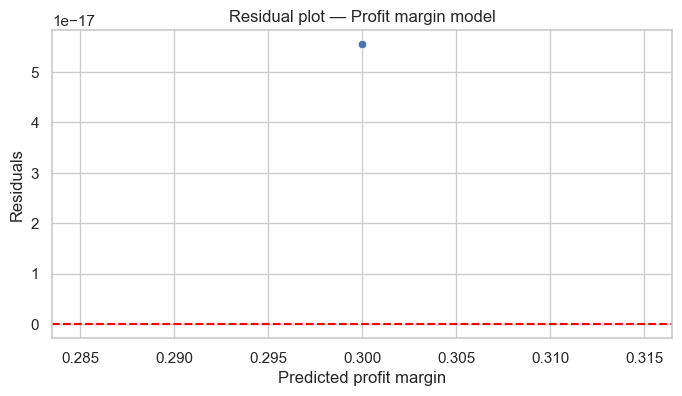

In [8]:
# Cell 10: residual plots for sales
residuals = y_test - y_pred
plt.figure(figsize=(8,4))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted sales')
plt.ylabel('Residuals')
plt.title('Residual plot — Sales model')
plt.show()

# Cell 11: residual plots for profit margin
residuals_m = y_test_m - y_pred_m
plt.figure(figsize=(8,4))
sns.scatterplot(x=y_pred_m, y=residuals_m)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted profit margin')
plt.ylabel('Residuals')
plt.title('Residual plot — Profit margin model')
plt.show()

In [9]:
df_encoded = pd.get_dummies(df, columns=['region'], drop_first=True)